In [33]:
# MATTHEW PFLEGER
# CS 4265-01
# HOMEWORK 7
# DEC 1 2025

## Dataset: https://www.kaggle.com/datasets/erdemtaha/cancer-data

In [1]:
!pip install pennylane
!pip install scikit-learn matplotlib numpy pandas
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 121.1 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

In [35]:
# Import dataset
data_path = "/content/sample_data/Cancer_Data.csv"
df1 = pd.read_csv(data_path)
df2 = df1[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'diagnosis']]

df2.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,M


In [31]:
# Features
X = df2[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean']]

## Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

## PCA fitting and transforming
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)

## Normalize the output to range (-1,1)
minmax_scale = MinMaxScaler((-1,1))
X = minmax_scale.fit_transform(X).astype('float64')

# Target
y = df2['diagnosis'].astype('category').cat.codes.astype('float64')

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=88)

In [32]:
# Classical SVM model
classifier = SVC(kernel='linear', random_state=73)
classifier.fit(X_train, y_train)

## Eval SVM model
y_pred_classical = classifier.predict(X_test)
accuracy_classical = accuracy_score(y_test, y_pred_classical)
print(f"Classical SVM Accuracy: {accuracy_classical}")

Classical SVM Accuracy: 0.9473684210526315


In [34]:
# Define quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum circuit with feature map
def feature_map(x):
  for i in range(n_qubits):
    qml.Hadamard(wires=i)
    qml.RY(x[i], wires=i)

  # Entangling operation
  for i in range(n_qubits-1):
    qml.CNOT(wires=[i, i+1])
    qml.RY(np.pi/4, wires=i+1)
    qml.CNOT(wires=[i, i+1])

In [42]:
# Functions to compute quantum kernel
@qml.qnode(dev)
def quantum_kernel(x1, x2):
  feature_map(x1)
  qml.adjoint(feature_map)(x2)
  return qml.expval(qml.PauliZ(0))

def compute_kernel_matrix(rows_data, cols_data, desc="Kernel Matrix"):
  kernel_matrix = np.zeros((len(rows_data), len(cols_data)))
  for i, x1 in enumerate(rows_data):
    for j, x2 in enumerate(cols_data):
      kernel_matrix[i, j] = quantum_kernel(x1, x2)
  return kernel_matrix

print("Computing training kernel matrix...")
kernel_matrix_train = compute_kernel_matrix(X_train, X_train, desc="Training Kernel Matrix")

print("Computing testing kernel matrix...")
kernel_matrix_test = compute_kernel_matrix(X_test, X_train, desc='Testing Kernel Matrix')

Computing training kernel matrix...
Computing testing kernel matrix...


In [43]:
# QSVM model using quantum kernel
qsvm_classifier = SVC(kernel='precomputed', random_state=73)
qsvm_classifier.fit(kernel_matrix_train, y_train)

## Predict using QSVM model
y_pred_qsvm = qsvm_classifier.predict(kernel_matrix_test)

## Eval QSVM model
accuracy_qsvm = accuracy_score(y_test, y_pred_qsvm)
print(f"Quantum QSVM accuracy {accuracy_qsvm}")


Quantum QSVM accuracy 0.9736842105263158


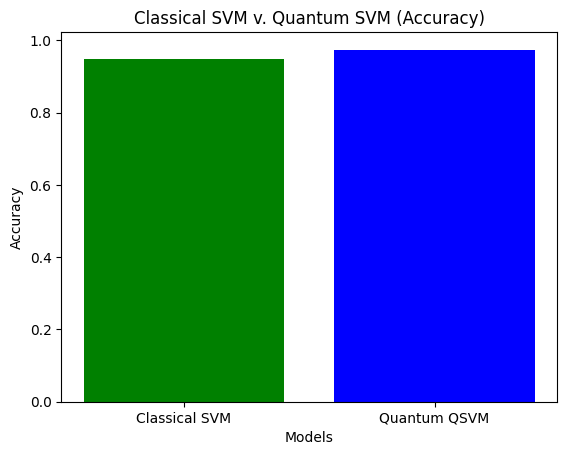

In [44]:
# Plotting comparisons of models accuracies
models = ['Classical SVM', 'Quantum QSVM']
accuracies = [accuracy_classical, accuracy_qsvm]
plt.bar(models, accuracies, color=['green', 'blue'])

## Add title and label axes
plt.title('Classical SVM v. Quantum SVM (Accuracy)')
plt.xlabel('Models')
plt.ylabel('Accuracy')

## Show plot
plt.show()